In [ ]:
import ibmos2spark
from pyspark.sql.functions import count,countDistinct
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
spark = SparkSession.builder.getOrCreate()
plt.style.use('ggplot')

# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'api_key': 'Mah02bEi7GKj9hczaiL-NL7wB1ZrY7LfQx-6-TpVvu3W',
    'service_id': 'iam-ServiceId-b028ce9d-a803-48bc-bdc5-d57d88989644',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token'}

configuration_name = 'os_9e785eb379d44200ba4fa10da519fc98_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')


df = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option("inferSchema", "true")\
  .load(cos.url('AZFI_APPRX_Reviewer_Processed.csv', 'amazonreviews-donotdelete-pr-qdqutmdfrupodw'))
df.take(5)

In [ ]:
schema = StructType([
    StructField("user", StringType(), True),
    StructField("product", StringType(), True),
    StructField("rating", DoubleType(), True),
    StructField("timestamp", IntegerType(), True)])
exact_data = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .schema(schema)\
  .load(cos.url('ratings.csv', 'amazonreviews-donotdelete-pr-qdqutmdfrupodw'))
exact_data.take(5)

In [3]:
df.createOrReplaceTempView("results")
max_emit_num = spark.sql("SELECT item,MAX(emitNum) as emitNum FROM results GROUP BY item")
gr = exact_data.groupBy("user").agg(count("user").alias('count')).orderBy('count',ascending=False)
gr.show()

+--------------+-----+
|          user|count|
+--------------+-----+
|A14OJS0VWMOSWO|44557|
|   AFVQZQ8PW0L|29044|
|A328S9RN3U5M68| 9773|
| A9Q28YTLYREO7| 9243|
|A2EDZH51XHFA9B| 6431|
| A320TMDV6KCFU| 6195|
|A2F6N60Z96CAJI| 6171|
|A2OJW07GQRNJUT| 5692|
|A16CZRQL23NOIW| 5613|
|A2AIMXT9PLAM12| 5494|
|A1S3C5OFU508P3| 5378|
| AHD101501WCN1| 5155|
|A281NPSIMI1C2R| 5093|
|A13QTZ8CIMHHG4| 4797|
|A2NJO6YE954DBH| 4794|
|A1D2C0WDCSHUWZ| 4781|
|A1X8VZWTOG8IS6| 4730|
|A2R6RA8FRBS608| 4420|
|A2TX179XAT5GRP| 4290|
|A2WQY1B8ZS7QRZ| 4253|
+--------------+-----+
only showing top 20 rows



In [25]:
counts_desc = gr.select('count').orderBy('count',ascending=False)
counts_asc = gr.select('count').orderBy('count',ascending=True)

In [ ]:
ax = counts_desc.toPandas().plot(logy=True, logx=False)
plt.xlabel('Log (Item count index)')
plt.ylabel('Log (Item count)')
plt.show()

In [6]:
ax = counts_asc.toPandas().plot(logy=True, logx=False)
plt.rcParams["figure.figsize"] =(9,9)
plt.xlabel('Log (Item count index - Ascending)')
plt.ylabel('Log (Item count)')
plt.show()

In [7]:
distinct_keys = exact_data.agg(countDistinct("user"))
distinct_keys.show()

+--------------------+
|count(DISTINCT user)|
+--------------------+
|            21176521|
+--------------------+



/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


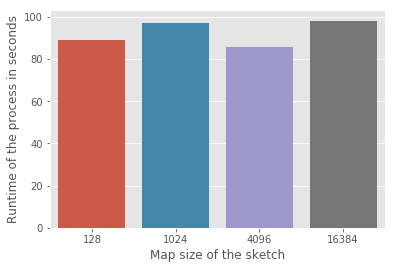

In [8]:
runtime = df.select('mapSize','runtime').distinct()
df_runtime = runtime.toPandas()
ax = sns.barplot( x="mapSize", y="runtime", data=df_runtime)
plt.xlabel('Map size of the sketch')
# Set y-axis label
plt.ylabel('Runtime of the process in seconds')
plt.show()

In [9]:
experiment1 = df.filter(df['experimentNum'] == 1)
experiment1.createOrReplaceTempView("experiment1")
experiment1 = spark.sql("SELECT mapSize,experimentNum,runtime,thread,a.emitNum,estimate,a.item as item,lowerBound,upperBound FROM experiment1 AS a INNER JOIN (SELECT item, max(emitNum) AS emitNum FROM experiment1 GROUP BY item) AS b ON a.item =  b.item AND a.emitNum = b.emitNum ORDER BY estimate DESC")
df_compare1 = experiment1.join(gr, experiment1.item == gr.user)
df_compare1.createOrReplaceTempView("df_compare1")
diff1 = spark.sql('SELECT mapSize,user,estimate,lowerBound,upperBound,count, estimate - count as diff, round((100.0*ABS(estimate - count)) / count,3)as diff_percent ,lowerBound - count as diffLower,upperBound - count as diffUpper  FROM df_compare1 ORDER BY count DESC')
diff1.show()


+-------+--------------+--------+----------+----------+-----+-----+------------+---------+---------+
|mapSize|          user|estimate|lowerBound|upperBound|count| diff|diff_percent|diffLower|diffUpper|
+-------+--------------+--------+----------+----------+-----+-----+------------+---------+---------+
|    128|A14OJS0VWMOSWO|   43357|     21684|     43357|44557|-1200|       2.693|   -22873|    -1200|
|    128|   AFVQZQ8PW0L|   25430|     12715|     25430|29044|-3614|      12.443|   -16329|    -3614|
|    128|A13OFOB1394G31|      41|        21|        41| 1975|-1934|      97.924|    -1954|    -1934|
+-------+--------------+--------+----------+----------+-----+-----+------------+---------+---------+



In [10]:
diff1.describe('diff', 'diff_percent','diffLower','diffUpper').show()

+-------+-------------------+--------------------+-------------------+-------------------+
|summary|               diff|        diff_percent|          diffLower|          diffUpper|
+-------+-------------------+--------------------+-------------------+-------------------+
|  count|                  3|                   3|                  3|                  3|
|   mean|-2249.3333333333335|37.68666666666666...|-13718.666666666666|-2249.3333333333335|
| stddev| 1237.5077104136901|  52.394349603114016| 10701.005575801431| 1237.5077104136901|
|    min|              -3614|               2.693|             -22873|              -3614|
|    max|              -1200|              97.924|              -1954|              -1200|
+-------+-------------------+--------------------+-------------------+-------------------+



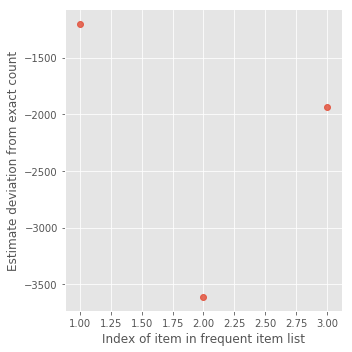

In [11]:
pd_diff1 = diff1.toPandas()
pd_diff1['s_index'] = range(1, len(pd_diff1) + 1)
ax = sns.lmplot( x="s_index", y="diff", data=pd_diff1, fit_reg=False)
plt.xlabel('Index of item in frequent item list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact count')
plt.show()

In [12]:
experiment2 = df.filter(df['experimentNum'] == 2)
experiment2.createOrReplaceTempView("experiment2")
experiment2 = spark.sql("SELECT mapSize,experimentNum,runtime,thread,a.emitNum,estimate,a.item as item,lowerBound,upperBound FROM experiment2 AS a INNER JOIN (SELECT item, max(emitNum) AS emitNum FROM experiment2 GROUP BY item) AS b ON a.item =  b.item AND a.emitNum = b.emitNum ORDER BY estimate DESC")
df_compare2 = experiment2.join(gr, experiment2.item == gr.user)
df_compare2.createOrReplaceTempView("df_compare2")
diff2 = spark.sql('SELECT mapSize,user,estimate,lowerBound,upperBound,count, estimate - count as diff, round((100.0*ABS(estimate - count)) / count,3)as diff_percent ,lowerBound - count as diffLower,upperBound - count as diffUpper  FROM df_compare2 ORDER BY count DESC')
diff2.show()

+-------+--------------+--------+----------+----------+-----+-----+------------+---------+---------+
|mapSize|          user|estimate|lowerBound|upperBound|count| diff|diff_percent|diffLower|diffUpper|
+-------+--------------+--------+----------+----------+-----+-----+------------+---------+---------+
|   1024|A14OJS0VWMOSWO|   44557|     36146|     44557|44557|    0|       0.000|    -8411|        0|
|   1024|   AFVQZQ8PW0L|   29045|     20654|     29045|29044|    1|       0.003|    -8390|        1|
|   1024| A9Q28YTLYREO7|    8669|      4336|      8669| 9243| -574|       6.210|    -4907|     -574|
|   1024|A2EDZH51XHFA9B|      15|         8|        15| 6431|-6416|      99.767|    -6423|    -6416|
|   1024| A320TMDV6KCFU|    4068|      2034|      4068| 6195|-2127|      34.334|    -4161|    -2127|
|   1024|A2F6N60Z96CAJI|    6126|      3063|      6126| 6171|  -45|       0.729|    -3108|      -45|
|   1024|A2OJW07GQRNJUT|    4527|      2264|      4527| 5692|-1165|      20.467|    -3428| 

In [13]:
diff2.describe('diff', 'diff_percent','diffLower','diffUpper').show()

+-------+-------------------+--------------------+-------------------+-------------------+
|summary|               diff|        diff_percent|          diffLower|          diffUpper|
+-------+-------------------+--------------------+-------------------+-------------------+
|  count|               2989|                2989|               2989|               2989|
|   mean|-124.24355971896955|75.97775108732017...|-143.03011040481766|-124.24355971896955|
| stddev| 383.61830802834004|   29.99387157071935| 484.19971971385087| 383.61830802834004|
|    min|              -6416|               0.000|              -8411|              -6416|
|    max|                347|             100.000|                  0|                347|
+-------+-------------------+--------------------+-------------------+-------------------+



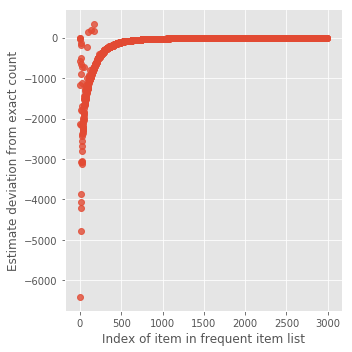

In [14]:
pd_diff2 = diff2.toPandas()
pd_diff2['s_index'] = range(1, len(pd_diff2) + 1)
ax = sns.lmplot( x="s_index", y="diff", data=pd_diff2, fit_reg=False)
plt.xlabel('Index of item in frequent item list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact count')
plt.show()

In [15]:
pd_diff2

,mapSize,user,estimate,lowerBound,upperBound,count,diff,diff_percent,diffLower,diffUpper,s_index
0,1024,A14OJS0VWMOSWO,44557,36146,44557,44557,0,0.000,-8411,0,1
1,1024,AFVQZQ8PW0L,29045,20654,29045,29044,1,0.003,-8390,1,2
2,1024,A9Q28YTLYREO7,8669,4336,8669,9243,-574,6.210,-4907,-574,3
3,1024,A2EDZH51XHFA9B,15,8,15,6431,-6416,99.767,-6423,-6416,4
4,1024,A320TMDV6KCFU,4068,2034,4068,6195,-2127,34.334,-4161,-2127,5
5,1024,A2F6N60Z96CAJI,6126,3063,6126,6171,-45,0.729,-3108,-45,6
6,1024,A2OJW07GQRNJUT,4527,2264,4527,5692,-1165,20.467,-3428,-1165,7
7,1024,A1S3C5OFU508P3,4721,2362,4721,5378,-657,12.216,-3016,-657,8
8,1024,AHD101501WCN1,3361,1681,3361,5155,-1794,34.801,-3474,-1794,9
9,1024,A2NJO6YE954DBH,2,1,2,4794,-4792,99.958,-4793,-4792,10


In [16]:
experiment3 = df.filter(df['experimentNum'] == 3)
experiment3.createOrReplaceTempView("experiment3")
experiment3 = spark.sql("SELECT mapSize,experimentNum,runtime,thread,a.emitNum,estimate,a.item as item,lowerBound,upperBound FROM experiment3 AS a INNER JOIN (SELECT item, max(emitNum) AS emitNum FROM experiment3 GROUP BY item) AS b ON a.item =  b.item AND a.emitNum = b.emitNum ORDER BY estimate DESC")
df_compare3 = experiment3.join(gr, experiment3.item == gr.user)
df_compare3.createOrReplaceTempView("df_compare3")
diff3 = spark.sql('SELECT mapSize,user,estimate,lowerBound,upperBound,count, estimate - count as diff, round((100.0*ABS(estimate - count)) / count,3)as diff_percent ,lowerBound - count as diffLower,upperBound - count as diffUpper  FROM df_compare3 ORDER BY count DESC')
diff3.show()

+-------+--------------+--------+----------+----------+-----+----+------------+---------+---------+
|mapSize|          user|estimate|lowerBound|upperBound|count|diff|diff_percent|diffLower|diffUpper|
+-------+--------------+--------+----------+----------+-----+----+------------+---------+---------+
|   4096|A14OJS0VWMOSWO|   44557|     42458|     44557|44557|   0|       0.000|    -2099|        0|
|   4096|   AFVQZQ8PW0L|   29044|     26950|     29044|29044|   0|       0.000|    -2094|        0|
|   4096|A328S9RN3U5M68|    9773|      7470|      9773| 9773|   0|       0.000|    -2303|        0|
|   4096| A9Q28YTLYREO7|    9244|      6943|      9244| 9243|   1|       0.011|    -2300|        1|
|   4096|A2EDZH51XHFA9B|    6431|      4122|      6431| 6431|   0|       0.000|    -2309|        0|
|   4096| A320TMDV6KCFU|    6200|      4108|      6200| 6195|   5|       0.081|    -2087|        5|
|   4096|A2F6N60Z96CAJI|    6171|      3862|      6171| 6171|   0|       0.000|    -2309|        0|


In [17]:
diff3.describe('diff', 'diff_percent','diffLower','diffUpper').show()

+-------+------------------+--------------------+------------------+------------------+
|summary|              diff|        diff_percent|         diffLower|         diffUpper|
+-------+------------------+--------------------+------------------+------------------+
|  count|             63422|               63422|             63422|             63422|
|   mean|-35.83573523383053|71.19180473652675...|-41.89924631831226|-35.83573523383053|
| stddev|107.22342740373958|  32.689945220470555|135.12002552799552|107.22342740373958|
|    min|             -3594|               0.000|             -3714|             -3594|
|    max|               573|             100.000|                 0|               573|
+-------+------------------+--------------------+------------------+------------------+



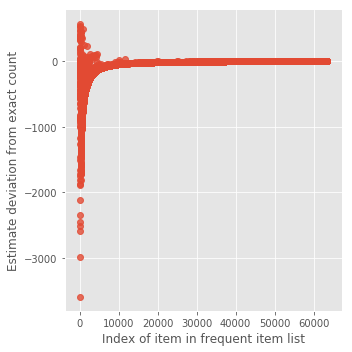

In [18]:
pd_diff3 = diff3.toPandas()
pd_diff3['s_index'] = range(1, len(pd_diff3) + 1)
ax = sns.lmplot( x="s_index", y="diff", data=pd_diff3, fit_reg=False)
plt.xlabel('Index of item in frequent item list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact count')
plt.show()

In [19]:
experiment4 = df.filter(df['experimentNum'] == 4)
experiment4.createOrReplaceTempView("experiment4")
experiment4 = spark.sql("SELECT mapSize,experimentNum,runtime,thread,a.emitNum,estimate,a.item as item,lowerBound,upperBound FROM experiment4 AS a INNER JOIN (SELECT item, max(emitNum) AS emitNum FROM experiment4 GROUP BY item) AS b ON a.item =  b.item AND a.emitNum = b.emitNum ORDER BY estimate DESC")
df_compare4 = experiment4.join(gr, experiment4.item == gr.user)
df_compare4.createOrReplaceTempView("df_compare4")
diff4 = spark.sql('SELECT mapSize,user,estimate,lowerBound,upperBound,count, estimate - count as diff, round((100.0*ABS(estimate - count)) / count,3)as diff_percent ,lowerBound - count as diffLower,upperBound - count as diffUpper  FROM df_compare4 ORDER BY count DESC')
diff4.show()

+-------+--------------+--------+----------+----------+-----+----+------------+---------+---------+
|mapSize|          user|estimate|lowerBound|upperBound|count|diff|diff_percent|diffLower|diffUpper|
+-------+--------------+--------+----------+----------+-----+----+------------+---------+---------+
|  16384|A14OJS0VWMOSWO|   44557|     44039|     44557|44557|   0|       0.000|     -518|        0|
|  16384|   AFVQZQ8PW0L|   29044|     28527|     29044|29044|   0|       0.000|     -517|        0|
|  16384|A328S9RN3U5M68|    9773|      9204|      9773| 9773|   0|       0.000|     -569|        0|
|  16384| A9Q28YTLYREO7|    9243|      8674|      9243| 9243|   0|       0.000|     -569|        0|
|  16384|A2EDZH51XHFA9B|    6431|      5861|      6431| 6431|   0|       0.000|     -570|        0|
|  16384| A320TMDV6KCFU|    6195|      5679|      6195| 6195|   0|       0.000|     -516|        0|
|  16384|A2F6N60Z96CAJI|    6171|      5601|      6171| 6171|   0|       0.000|     -570|        0|


In [20]:
diff4.describe('diff', 'diff_percent','diffLower','diffUpper').show()

+-------+-------------------+--------------------+------------------+-------------------+
|summary|               diff|        diff_percent|         diffLower|          diffUpper|
+-------+-------------------+--------------------+------------------+-------------------+
|  count|             277532|              277532|            277532|             277532|
|   mean|-17.875286453454017|67.38839867474741...|-22.46863064439416|-17.875286453454017|
| stddev| 42.966403298707434|   33.81353766335583| 56.57840447872604| 42.966403298707434|
|    min|              -1049|               0.000|             -1055|              -1049|
|    max|                499|             100.000|                 0|                499|
+-------+-------------------+--------------------+------------------+-------------------+



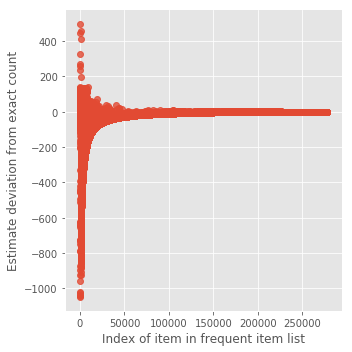

In [21]:
pd_diff4 = diff4.toPandas()
pd_diff4['s_index'] = range(1, len(pd_diff4) + 1)
ax = sns.lmplot( x="s_index", y="diff", data=pd_diff4, fit_reg=False)
plt.xlabel('Index of item in frequent item list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact count')
plt.show()

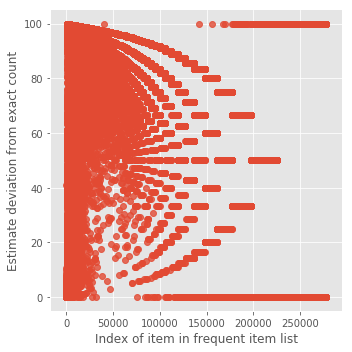

In [22]:
pd_diff4 = diff4.toPandas()
pd_diff4['s_index'] = range(1, len(pd_diff4) + 1)
ax = sns.lmplot( x="s_index", y="diff_percent", data=pd_diff4, fit_reg=False)
plt.xlabel('Index of item in frequent item list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact count')
plt.show()

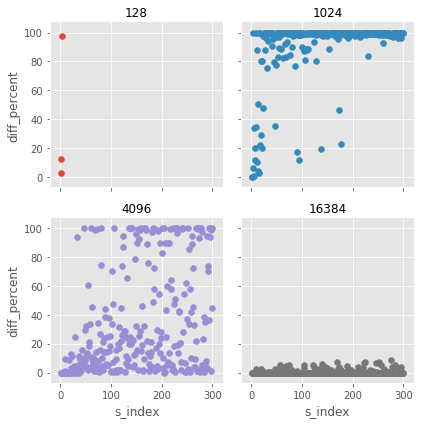

In [23]:
head = 300
frames = [pd_diff1.head(head), pd_diff2.head(head), pd_diff3.head(head),pd_diff4.head(head)]
pd_df = pd.concat(frames, ignore_index=True)
# multiple line plot
# Create a grid : initialize it
g = sns.FacetGrid(pd_df, col='mapSize', hue='mapSize', col_wrap=2, )
 
# Add the line over the area with the plot function
g = g.map(plt.scatter, 's_index' ,'diff_percent')
 
# Fill the area with fill_between
#g = g.map(plt.fill_between, 'years', 'value', alpha=0.2).set_titles("{col_name} country")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plo
# plt.subplots_adjust(top=0.92)
# g = g.fig.suptitle('Comparison of different map sizes in the Frequent Item Sketch')
 
plt.show()

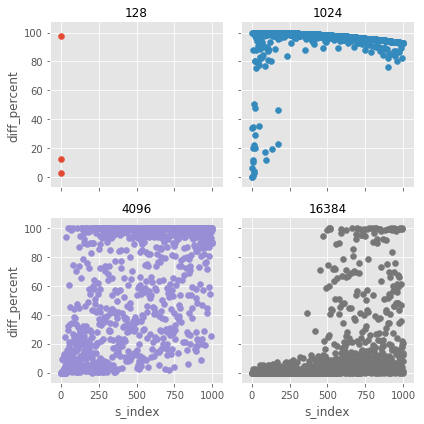

In [24]:
head = 1000
frames = [pd_diff1.head(head), pd_diff2.head(head), pd_diff3.head(head),pd_diff4.head(head)]
pd_df = pd.concat(frames, ignore_index=True)
# multiple line plot
# Create a grid : initialize it
g = sns.FacetGrid(pd_df, col='mapSize', hue='mapSize', col_wrap=2, )
 
# Add the line over the area with the plot function
g = g.map(plt.scatter, 's_index' ,'diff_percent')
 
# Fill the area with fill_between
#g = g.map(plt.fill_between, 'years', 'value', alpha=0.2).set_titles("{col_name} country")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plo
# plt.subplots_adjust(top=0.92)
# g = g.fig.suptitle('Comparison of different map sizes in the Frequent Item Sketch')
 
plt.show()